# Linear Systems and Signal Convolution
## Introduction


Digital Filter is a model of a physical system

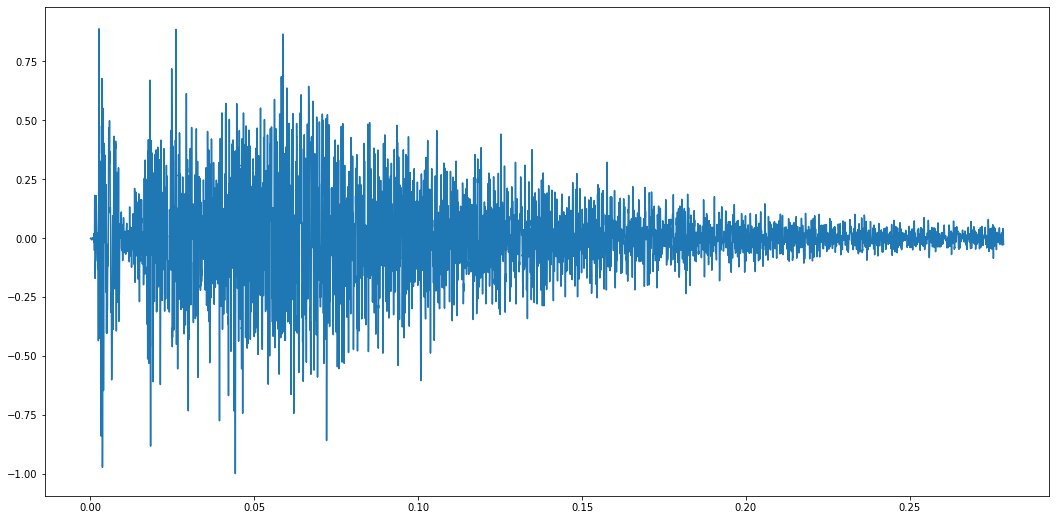

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
f_rate, signal = wavfile.read('record3.wav')

time = np.linspace(
    0, # start
    len(signal) / f_rate,
    num = len(signal)
)
signal = [s[0] for s in signal]
norm = np.max(np.abs(signal))
signal = signal/norm
plt.figure(figsize=(18, 9))
plt.plot(time, signal)
plt.show()

In [2]:
from IPython.display import Audio
Audio(signal/norm, rate=f_rate)

# Task 1

In [24]:
import time
from collections import defaultdict
audios = ['DSP_2020_A3_DATA/drums.wav',
         #'DSP_2020_A3_DATA/music_20s_8000.wav',
#          'DSP_2020_A3_DATA/speech.wav',
#          'DSP_2020_A3_DATA/violin.wav',
          'DSP_2020_A3_DATA/voice.wav'
]
# slowest with for loops
def loops(signal, kernal):
    flen =  len(signal) - len(kernal) + 1
    trans_signal = [(signal[i:i+len(kernal)]*kernal[::-1]).sum() for i in range(flen)]
    return trans_signal

def striding(signal, kernal):
    trans_signal = []
    signals = np.lib.stride_tricks.sliding_window_view(signal, len(kernal))
    for s in signals:
        trans_signal.append(np.dot(s, np.flip(kernal)))
    return trans_signal
        
def using_fft(signal, kernal):
    fflen =  len(signal) - len(kernal) + 1
    flen =  len(signal)
    ss = np.fft.fft(signal)
    flen -= int((len(signal) - len(kernal))/2) + len(kernal)
    kk =  np.zeros(int((len(signal) - len(kernal))/2))
    kk = np.append(kk, kernal)
    kk = np.append(kk, np.zeros(flen))
    kk = np.fft.fft(kk)
    new_signal = np.fft.ifft(kk * ss)
    new_signal = np.real(new_signal)
    return np.fft.fftshift(new_signal)[:fflen]
    
methods = [loops, striding, using_fft]
times = defaultdict(list)
for method in methods:
    for audio in audios:
        start = time.time()
        fs, ex_signal = wavfile.read(audio)
        try:
          ex_signal = [s[0] for s in ex_signal]
        except:
            pass
        trans_signal = method(ex_signal, signal)
        times[method.__name__].append(time.time()-start)

    

<ipython-input-24-3ad460cc074f>:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, ex_signal = wavfile.read(audio)


loops


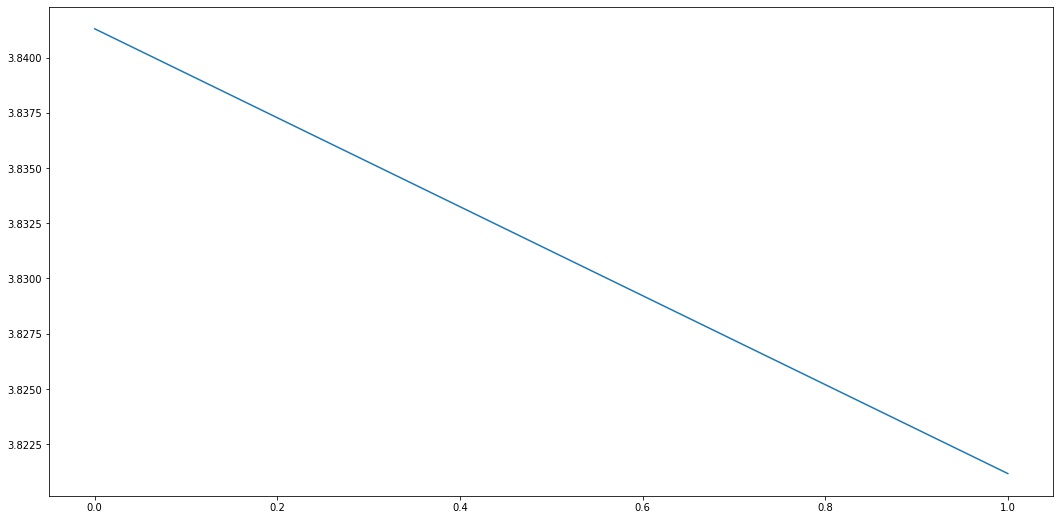

striding


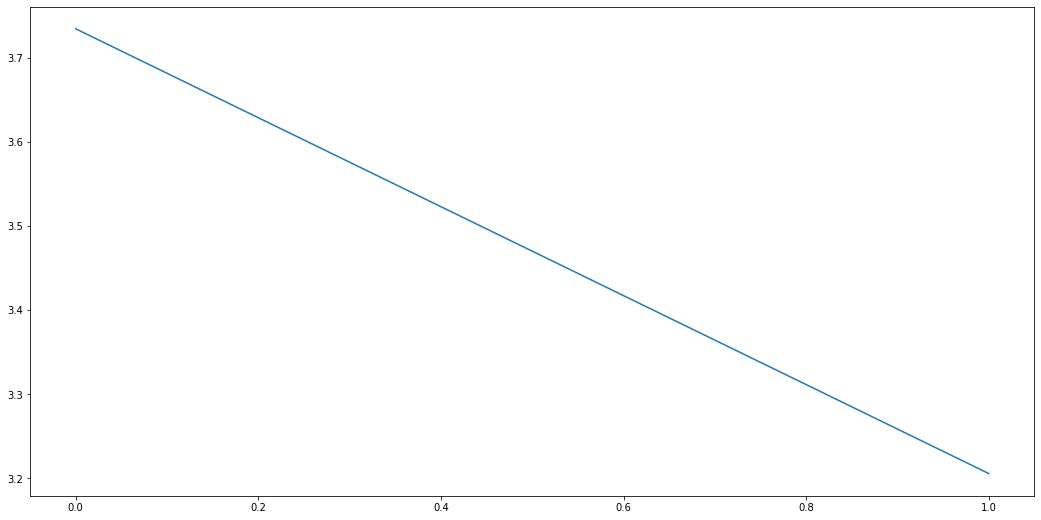

using_fft


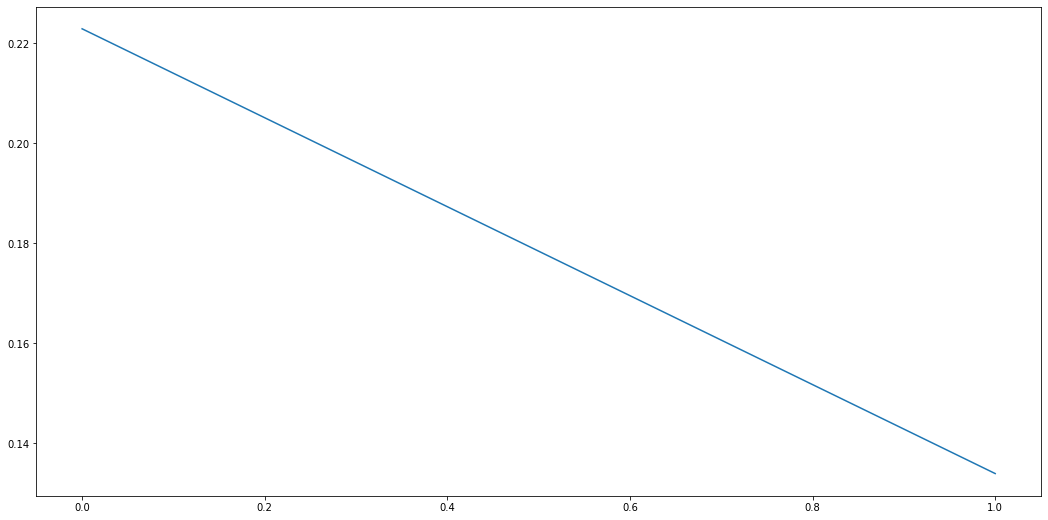

In [8]:
for t in times:
    print(t)
    plt.figure(figsize=(18, 9))
    plt.plot(times[t])
    plt.show()

In [26]:
# here we can listen
path_to_audio = 'DSP_2020_A3_DATA/voice.wav'
method = striding
fs, ex_signal = wavfile.read(path_to_audio)
try:
    ex_signal = [s[0] for s in ex_signal]
except:
    pass
trans_signal = method(ex_signal, signal)
print(trans_signal[:10])
Audio(trans_signal, rate=fs)

<ipython-input-26-f98abe1b59ed>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, ex_signal = wavfile.read(path_to_audio)


[594.4080946680178, 729.5563127359801, 658.1594529883057, 399.4033981029561, 132.36030021180628, -124.93070264296954, -405.10134450686076, -557.7797218896766, -504.86780550695335, -378.394833778433]


In [4]:
# тесты 
s = np.array([0,0,0,1,1,1,0,0,0])
k = np.array([2,2])

In [5]:
loops(s, k)

[0, 0, 2, 4, 4, 2, 0, 0]

In [6]:
np.real(striding(s, k))

array([0, 0, 2, 4, 4, 2, 0, 0])

## Frequency Filtering with IIR Filters

- https://www.sciencedirect.com/topics/engineering/iir-filters
- https://www.youtube.com/watch?v=jL_1DwUMD2w&ab_channel=PhysicsVideosbyEugeneKhutoryansky
- https://www.youtube.com/watch?v=9yNQBWKRSs4&ab_channel=BarryVanVeen

I guess I need to have same results:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html

### Some Theory
References:
1. https://dspguru.com/dsp/faqs/iir/basics/
2. https://www.advsolned.com/difference-between-iir-and-fir-filters-a-practical-design-guide/

In this section we are going to dicuss *Infinite Impulse Response*(IIR) filters. 

Essentially IIR filters are ...

**Why IIR is infinite?**
Because, IIR has feedback term...

there are feedforward and feedback terms

Now let us observe the canonical representation of the IIR filter

$$
%     y_0 = (b \cdot x_0) + (a_1 \cdot y_1) + (a_2 \cdot y_2)
y(n) = \sum_{k=0}^{q} b_k x (n - k) - \sum_{k=1}^{p} a_k y (n - k)
$$

where:
- $y(n)$ is a nth output signal value
- $x(n)$ is a nth input signal value
- $b_k$ is the kth term of feedforward coefficients
- $a_k$ is the kth term of feedback coefficients
<!-- - $y_0$ is a current signal response
- $y_1, y_2$ are two output samples
- $a_1, a_2$ are
- $x_0$ is an input
- $b$ is a -->

So let us understand how IIR filters differs from FIR filters
...

### Implement IIR filter

To implement IIR we will need to have one memory buffer and two sets of coefficients. 

In [1]:
import numpy as np
from scipy.io import wavfile

In [50]:
def IIR_filter(a, b: np.array):
    '''
    Returns a filter with given coefficients
    
    :param a - np.array with coefficients
    :param b - np.array with coefficients
    
    :returns function
    '''
    p = len(a)
    q = len(b)
    
    def func(signal: np.array):
#         breakpoint()
        
        # shift signal and
        # prepend zeroes to the signal
        shift = max(p, q)
        zeros = np.zeros(shift)
        signal = np.insert(signal, 0, zeros, axis=0)
        
        output = np.zeros(shift)
        for n, xn in enumerate(signal):
            # ignore zero terms
            if n < shift:
                continue

            feedforward = b[::-1] @ signal[n - q: n]
            feedback = a[::-1] @ output[n - p: n]
            
            yn = feedforward + feedback
            yn = np.array([yn])
            
            output = np.append(output, yn, axis=0)
        return output[3:]
    
    return func

In the following two cells we will create lowpass and highpass filters

- lowpass filter is 

- highpass filter is 

In [51]:
# Lowpass, starts cutting frequencies after 20Hz
# Better to listen in your headphones
a = [1.9733442497812987,
     -0.9736948719763]# coefficients for a_1 and a_2
b = [0.00008765554875401547,
     0.00017531109750803094,
     0.00008765554875401547] # coefficients for b_0, b_1 and b_2

lowpass_filter = IIR_filter(np.array(a), np.array(b))

In [52]:
# Highpass, starts passing frequencies after 3kHz
a = [-0.3769782747249014,
     -0.19680764477614976] # coefficients for a_1 and a_2
b = [0.40495734254626874,
     -0.8099146850925375,
     0.4049573425462687] # coefficients for b_0, b_1 and b_2

highpass_filter = IIR_filter(a, b)

In [53]:
# audio = 'DSP_2020_A3_DATA/voice.wav'
audio = 'DSP_2020_A3_DATA/drums.wav'
fs, ex_signal = wavfile.read(audio)

<ipython-input-53-10f5079056bf>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, ex_signal = wavfile.read(audio)


In [54]:
filtered_signal = lowpass_filter(ex_signal)

In [55]:
import matplotlib.pyplot as plt
from IPython.display import Audio

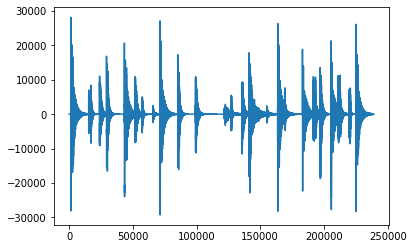

In [56]:
plt.plot(ex_signal)
plt.show()

Audio(ex_signal,rate=fs)

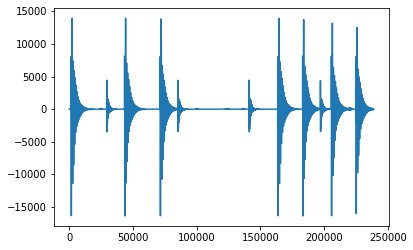

In [57]:
plt.plot(filtered_signal)
plt.show()

Audio(filtered_signal,rate=fs)

Now we will test our filter on music files

Apply these filters to a piece of music recording. After applying low pass filter you should hear mostly the bass. After a highpass filter, you will mostly hear piano and cymbals (metal plates).

In [58]:
filtered_signal = highpass_filter(ex_signal)

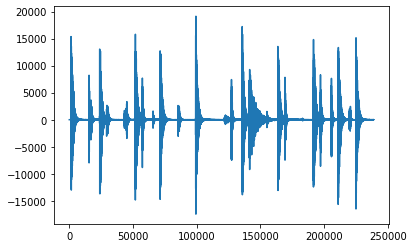

In [59]:
plt.plot(filtered_signal)
plt.show()

Audio(filtered_signal,rate=fs)

In [ ]:
# highpass_filter

As python loops are slow we can speed up computation using `numba`

`numba` is a dynamic Python compiler. 


In [3]:
from numba import jit